# Cruise Planning: Contemporaneous Sampling Along An Arbitrary Cruise Trajectory

<a href="https://colab.research.google.com/github/simonscmap/pycmap/blob/master/docs/CruisePlan.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

Planning for a future cruise expedition involves complex operations such as satisfying logistic constraints and finding the optimal cruise path according to the expedition's objectives. Archive and Near-Real-Time data can be utilized to simulate various cruise scenarios and to identify an optimal plan. This note notebook demonstrates how to sample any CMAP dataset using an arbitrary cruise trajectory. The cruise trajectory can represent a real cruise track (see [Cruises](https://colab.research.google.com/github/simonscmap/pycmap/blob/master/docs/Cruises.ipynb), and [Cruise Trajectory](https://colab.research.google.com/github/simonscmap/pycmap/blob/master/docs/CruiseTrajectory.ipynb)) or an arbitrary trajectory stored in a csv file with two columns (lat, and lon) indicating the cruise coordinates. The trajectory file does not require date/time columns.<br/>

To sample any dataset in CMAP, we will use the [sample](https://colab.research.google.com/github/simonscmap/pycmap/blob/master/docs/Sampling.ipynb#scrollTo=9g2myddS6sK6) function which requires sampling coordinates (`source` argument) and a list of datasets to be sampled (`targets` argument). In this example, the sampling coordinates are defined by the [AMT13](https://simonscmap.com/catalog/datasets/AMT13_Prochlorococcus_Abundance) cruise trajectory, and the target datasets are set by the `targets` dictionary as shown below. The table and variable names used in the `targets` dictionary can be found in the Simons CMAP catalog page (https://simonscmap.com/catalog).


**Note:** You need to register and get an API Key from [SimonsCMAP](https://simonscmap.com) to be able to run this notebook. <br/>

**Related Notebook:** [Cruise Planning Maps](https://github.com/simonscmap/pycmap/blob/master/docs/CruiseMap.ipynb)

Gathering metadata .... 
Sampling starts
Sampling finished                                                                                                    

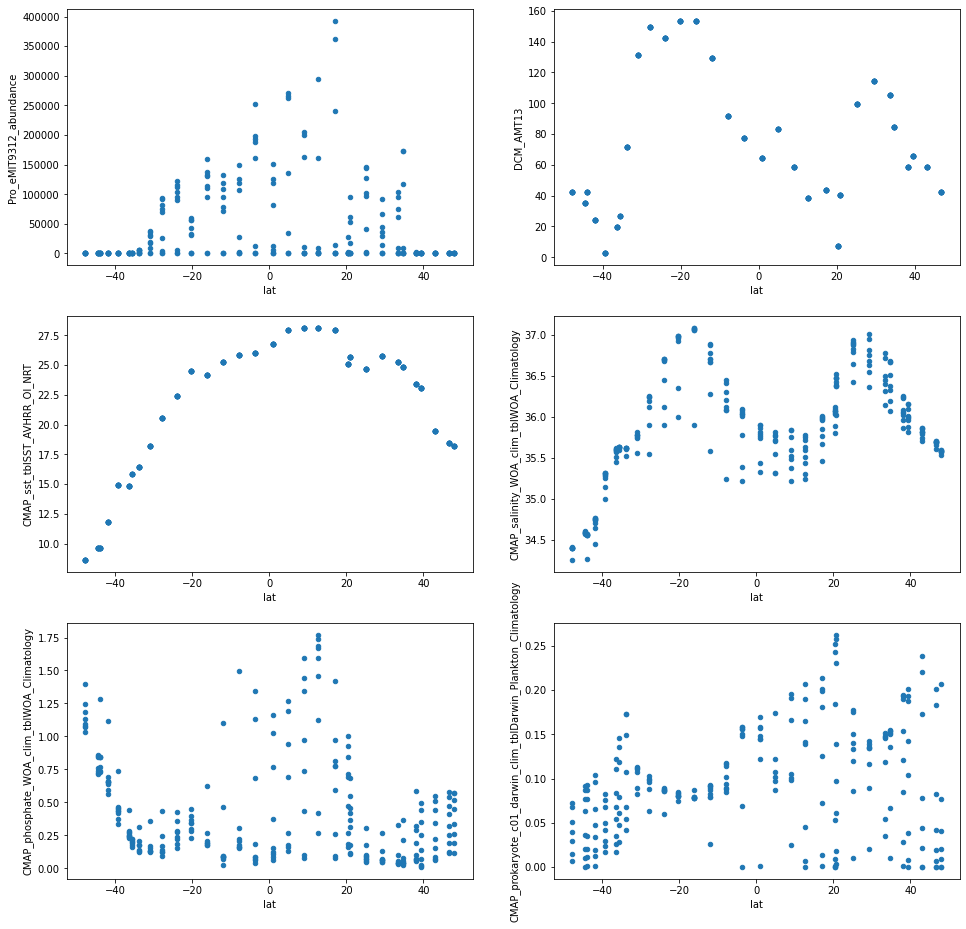

In [50]:
#!pip install pycmap -q     #uncomment to install pycmap, if necessary

import pycmap
import matplotlib.pyplot as plt

api = pycmap.API(token="<YOUR_API_KEY>")


targets = {
        # satellite SST
        "tblSST_AVHRR_OI_NRT": {
                                "variables": ["sst"],
                                "tolerances": [0, 0.25, 0.25, 0]
                                },      
    
        # Darwin Model (Climatology)
        "tblDarwin_Plankton_Climatology": {
                                           "variables": ["prokaryote_c01_darwin_clim", "prokaryote_c02_darwin_clim", "picoeukaryote_c03_darwin_clim", "cocco_c05_darwin_clim", "diazotroph_c10_darwin_clim", "diatom_c15_darwin_clim", "dinoflagellate_c26_darwin_clim", "zooplankton_c36_darwin_clim"],
                                           "tolerances": [0, 0.5, 0.5, 5]
                                          },
               
        # World Ocean Atlas Climatology
        "tblWOA_Climatology": {
                                "variables": ["density_WOA_clim", "salinity_WOA_clim", "nitrate_WOA_clim", "phosphate_WOA_clim", "silicate_WOA_clim", "oxygen_WOA_clim"],
                                "tolerances": [0, 0.75, 0.75, 5]
                                }    
        }






source = api.get_dataset("tblAMT13_Chisholm")  # cruise trajectory should be dataframe (you can make your own custom trajectory)
sample_df = pycmap.Sample(
                          source=source, 
                          targets=targets, 
                          replaceWithMonthlyClimatolog=True
                         )









#############  Simple Plot  #############
# A simple plot showing a few of the sampled variables along the cruise track at various latitudes.
# Top Panels (cruise data): Prochlorococcus MIT9312 strain, Deep Chlorophyll Maximum
# Middle Panels: Satellite SST, Salinity from World Ocean Atlas
# Bottom Panels: Phosphate from World Ocean Atlas, Prokaryot class concentration from Darwin model
##########################################

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
sample_df.plot(ax=axes[0, 0], x="lat", y="Pro_eMIT9312_abundance", kind="scatter")
sample_df.plot(ax=axes[0, 1], x="lat", y="DCM_AMT13", kind="scatter")

sample_df.plot(ax=axes[1, 0], x="lat", y="CMAP_sst_tblSST_AVHRR_OI_NRT", kind="scatter")
sample_df.plot(ax=axes[1, 1], x="lat", y="CMAP_salinity_WOA_clim_tblWOA_Climatology", kind="scatter")

sample_df.plot(ax=axes[2, 0], x="lat", y="CMAP_phosphate_WOA_clim_tblWOA_Climatology", kind="scatter")
_ = sample_df.plot(ax=axes[2, 1], x="lat", y="CMAP_prokaryote_c01_darwin_clim_tblDarwin_Plankton_Climatology", kind="scatter")